In [1]:
# param
BASE_FOLDER = '/home/jim/Documents/'
TAR_FILE_NAME = 'clean_data_0627.tar'
FOLDER_PATH = BASE_FOLDER + 'clean_data'
IMG_FOLDER_PATH = BASE_FOLDER + 'clean_data/img'
BATCH_SIZE = 8
NUM_EPOCHS = 100
LR = 0.0001
LOADER_THREAD = 4

In [2]:
import pandas as pd

train_df = pd.read_csv(BASE_FOLDER + 'clean_data/train.csv')
test_df = pd.read_csv(BASE_FOLDER + 'clean_data/test.csv')

In [3]:
import torch
import torchvision
import torch.nn as nn

class NvidiaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, 2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, 2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.ELU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*18, out_features=100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image

class SteeringDataset(Dataset):
    
    def __init__(self, df, folder_path, transform=None):
        self.df = df
        self.folder_path = folder_path
            
        self.transform = transform

    def __getitem__(self, index):
        key = self.df.im_key[index]
        steering = self.df.steering[index]
        img = Image.open(f'{self.folder_path}/{key}.jpg')

        if np.random.rand() < 0.5:
            img = transforms.functional.hflip(img)
            steering = -steering
        
        if self.transform:
            img = self.transform(img)
            
        steering = torch.tensor([steering]).float() / 100

        return img, steering

    def __len__(self):
        return len(self.df)

In [5]:
from torchvision import transforms

tf_compose = transforms.Compose([
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Resize((200, 66)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SteeringDataset(
    train_df,
    IMG_FOLDER_PATH,
    tf_compose,
)

test_dataset = SteeringDataset(
    test_df,
    IMG_FOLDER_PATH,
    tf_compose,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=LOADER_THREAD
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=LOADER_THREAD
)

   train_loss  test_loss        time
0    0.055495   0.054201  277.587690
1    0.054229   0.055705  267.762482


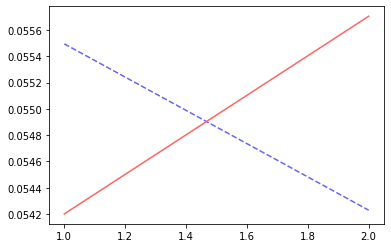

IntProgress(value=0)

epoch: 3 ...
train...


In [ ]:
import torch.optim as optim
import torch.nn.functional as F
import time
from ipywidgets import IntProgress
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import os

MODEL_FOLDER = BASE_FOLDER + 'model/'
MODEL_FN = 'steering_ep_{}.pth'
MODEL_PATH = MODEL_FOLDER + MODEL_FN

if not os.path.exists(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
def get_device():
    if torch.cuda.is_available():
        print('use CUDA')
        return torch.device('cuda')
    else:
        print('use CPU')
        return torch.device('cpu')

device = get_device()
model = NvidiaModel()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

result = pd.DataFrame(columns=['train_loss', 'test_loss', 'time'])

for epoch in range(NUM_EPOCHS):
    pbar = IntProgress()
    display(pbar)

    print(f'epoch: {epoch + 1} ...') 
    _t = time.time()

    # train
    
    model.train()
    train_loss = 0.0

    pbar.value = 0
    pbar.max = len(train_loader)

    print('train...')

    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = F.mse_loss(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += float(loss)

        pbar.value += 1


    train_loss /= len(train_loader)

    # eval
    model.eval()
    test_loss = 0.0

    pbar.value = 0
    pbar.max = len(test_loader)

    print('eval...')

    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = F.mse_loss(outputs, labels)

        test_loss += float(loss)

        pbar.value += 1
        
    test_loss /= len(test_loader)
    
    _dt = time.time() - _t

    torch.save(model.state_dict(), MODEL_PATH.format(epoch + 1))

    result = result.append({
        'train_loss': train_loss,
        'test_loss': test_loss,
        'time': _dt
    }, ignore_index=True)
    # save result
    result.to_csv(MODEL_FOLDER + 'result.csv', index=False)

    clear_output(wait=True)

    print(result)

    # plot
    x = range(1, len(result) + 1)

    plt.plot(x, list(result['train_loss']), '--', color=(100/255,100/255,255/255))
    plt.plot(x, list(result['test_loss']), color=(255/255,100/255,100/255))
    
    # save plt
    plt.savefig(MODEL_FOLDER + 'result.png')
    plt.show()